# Gaussian Linear Dynamical System 

In this notebook, we will look at how we can fit a "Gaussian Linear Dynamical System," using the StateSpaceDynamics package. This model is a powerful tool for analyzing time series data and understanding underlying latent processes. For a reference of the details of this model please refer to Chapter 13.3 of Pattern Recognition and Machine Learning by Christopher Bishop.

## Setup

In [1]:
# import the relevant packages
using StateSpaceDynamics
using LinearAlgebra
using Random
using Plots
using LaTeXStrings

## Simulate a Gaussian LDS model

In [2]:
# create a state-space model for the tutorial
obs_dim = 10
latent_dim = 2

# set up the state parameters
A = 0.95 * [cos(0.25) -sin(0.25); sin(0.25) cos(0.25)] 
Q = Matrix(0.1 * I(2))

x0 = [0.0; 0.0]
P0 = Matrix(0.1 * I(2))

# set up the observation parameters
C = randn(obs_dim, latent_dim)
R = Matrix(0.5 * I(10))


# create the state-space model
true_ssm = GaussianLDS(;A=A, 
                        Q=Q, 
                        C=C, 
                        R=R, 
                        x0=x0, 
                        P0=P0, 
                        obs_dim=obs_dim, 
                        latent_dim=latent_dim, 
                        fit_bool=fill(true, 6))

# simulate data from the model
tSteps = 500
latents, observations = StateSpaceDynamics.sample(true_ssm, tSteps, 1) # one trial for tutorial purposes

([0.08545693586677959 -0.04106851077661364 … -0.17941953347919898 -0.8031678436801699; 0.2337485327892584 -0.07968240189680179 … 1.275268375777739 0.7230446604198593;;;], [1.1473350875528947 -0.14291812088342026 … 1.3949722141153649 -1.2241528965890311; 1.2602541595335424 -0.08756713999918855 … 3.0007090965295897 1.8322583533176107; … ; -0.48934362786596747 -0.3021552851982049 … 0.5226301398942313 -1.2614820454175417; 0.12034697990294146 -0.3663676889071461 … 1.547084436214234 0.20864931997420233;;;])

In [3]:
H, _, _, _ = StateSpaceDynamics.Hessian(true_ssm, observations[:, :, 1], latents[:, :, 1])

(sparse([1, 2, 3, 4, 1, 2, 3, 4, 1, 2  …  999, 1000, 997, 998, 999, 1000, 997, 998, 999, 1000], [1, 1, 1, 1, 2, 2, 2, 2, 3, 3  …  998, 998, 999, 999, 999, 999, 1000, 1000, 1000, 1000], [-31.762079150348328, 1.1960619360366094, 9.204668006251124, 2.350337612917968, 1.1960619360366085, -39.46736282601516, -2.350337612917968, 9.204668006251124, 9.204668006251124, -2.350337612917968  …  -2.350337612917968, 9.204668006251124, 9.204668006251124, -2.350337612917968, -22.73707915034833, 1.196061936036609, 2.350337612917968, 9.204668006251124, 1.196061936036609, -30.442362826015163], 1000, 1000), [[-31.762079150348328 1.1960619360366085; 1.1960619360366094 -39.46736282601516], [-31.762079150348328 1.1960619360366085; 1.1960619360366094 -39.46736282601516], [-31.762079150348328 1.1960619360366085; 1.1960619360366094 -39.46736282601516], [-31.762079150348328 1.1960619360366085; 1.1960619360366094 -39.46736282601516], [-31.762079150348328 1.1960619360366085; 1.1960619360366094 -39.46736282601516],

In [5]:
using SparseArrays

In [6]:
function gaussian_entropy(H)
    n = size(H, 1)
    F = cholesky(-H)
    # Use logdet directly instead of accessing triangular factors
    logdet_H = 2 * sum(log.(diag(F)))
    return logdet_H
end

gaussian_entropy (generic function with 1 method)

In [7]:
@time gaussian_entropy(Symmetric(H))

  0.488933 seconds (278.95 k allocations: 19.719 MiB, 2.41% gc time, 97.40% compilation time)


3481.5251372002444

In [8]:
@time logdet(-H)

  0.578010 seconds (423.01 k allocations: 29.421 MiB, 98.83% compilation time)


3481.5251372002517

In [9]:
function gaussian_entropy(H)
    n = size(H, 1)
    ϵ = 1e-8
    L = cholesky(Symmetric(-H + ϵ*I)).L
    logdet_H = 2 * sum(log.(diag(L)))
    return 0.5 * (n * log(2π) + logdet_H)
end

gaussian_entropy (generic function with 1 method)

In [10]:
function check_matrix_condition(H)
    λ = eigvals(Symmetric(-Matrix(H)))
    κ = maximum(abs.(λ)) / minimum(abs.(λ))
    println("Condition number: ", κ)
    println("Eigenvalue range: [$(minimum(λ)), $(maximum(λ))]")
    return κ
end


check_matrix_condition (generic function with 1 method)

In [11]:
check_matrix_condition(H)

Condition number: 4.410156246749655
Eigenvalue range: [13.164575139960714, 58.057833289302955]


4.410156246749655

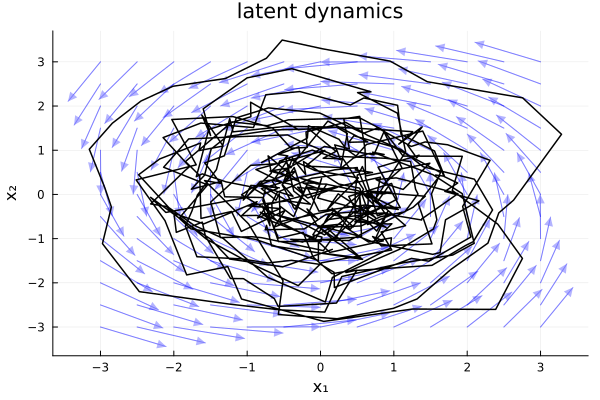

In [12]:
# Create a grid for the vector field
x = y = -3:0.5:3
X = repeat(x', length(y), 1)
Y = repeat(y, 1, length(x))

# Assuming x and y are your grid points
U = zeros(size(X))
V = zeros(size(Y))
for i in 1:size(X, 1)
    for j in 1:size(X, 2)
        v = A * [X[i,j], Y[i,j]]
        U[i,j] = v[1] - X[i,j]  # Change in x
        V[i,j] = v[2] - Y[i,j]  # Change in y
    end
end
# Normalize the vectors for better visualization
magnitude = @. sqrt(U^2 + V^2)
U_norm, V_norm = U ./ magnitude, V ./ magnitude

magnitude = @. sqrt(U^2 + V^2)
U_norm = U ./ magnitude
V_norm = V ./ magnitude

# Plot
p = quiver(X, Y, quiver=(U_norm, V_norm), color=:blue, alpha=0.3,
           linewidth=1, arrow=arrow(:closed, :head, 0.1, 0.1))
plot!(latents[1, :, 1], latents[2, :, 1], xlabel="x₁", ylabel="x₂", color=:black, linewidth=1.5, title="latent dynamics", legend=false)


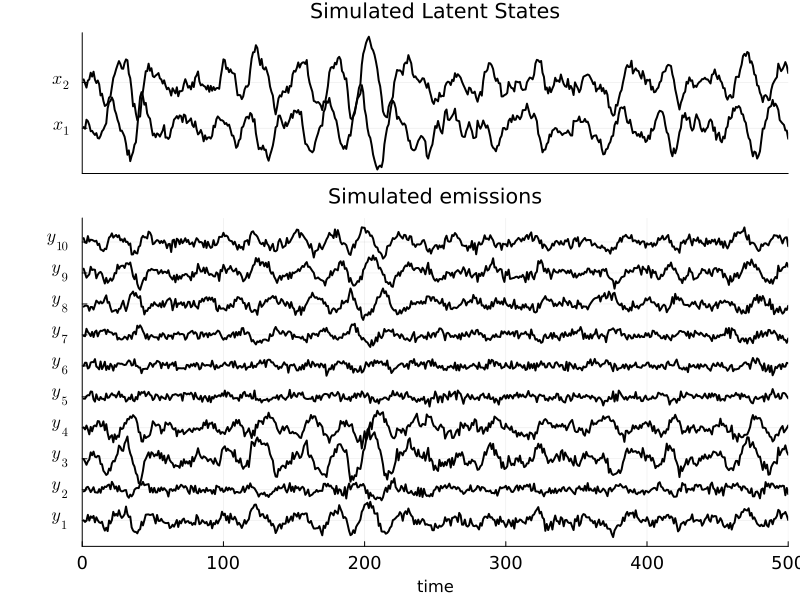

In [13]:
# Define parameters
state_dim = 2
obs_dim = 10
time_bins = 500

# Generate sample data
states = latents[:, :, 1]
emissions = observations[:, :, 1]

# Create the main plot
plot(size=(800, 600), layout=@layout[a{0.3h}; b])

# Plot the continuous latent states
lim_states = maximum(abs.(states))
for d in 1:state_dim
    plot!(1:time_bins, states[d, :] .+ lim_states * (d-1), color=:black, linewidth=2, label="", subplot=1)
end
plot!(subplot=1, yticks=(lim_states .* (0:state_dim-1), [L"x_%$d" for d in 1:state_dim]),
      xticks=[], xlims=(0, time_bins), title="Simulated Latent States",
      yformatter=y->"", tickfontsize=12)

# Plot the emissions
lim_emissions = maximum(abs.(emissions))
for n in 1:obs_dim
    plot!(1:time_bins, emissions[n, :] .- lim_emissions * (n-1), color=:black, linewidth=2, label="", subplot=2)
end
plot!(subplot=2, yticks=(-lim_emissions .* (obs_dim-1:-1:0), [L"y_{%$n}" for n in 1:obs_dim]),
      xlabel="time", xlims=(0, time_bins), title="Simulated emissions",
      yformatter=y->"", tickfontsize=12)

# Adjust layout
plot!(link=:x, size=(800, 600), left_margin=10Plots.mm)

# Display the plot
display(current())

# Uncomment to save the figure
# savefig("simulated_latent_states_and_emissions.png")

## Create and fit a Gaussian LDS model to Data

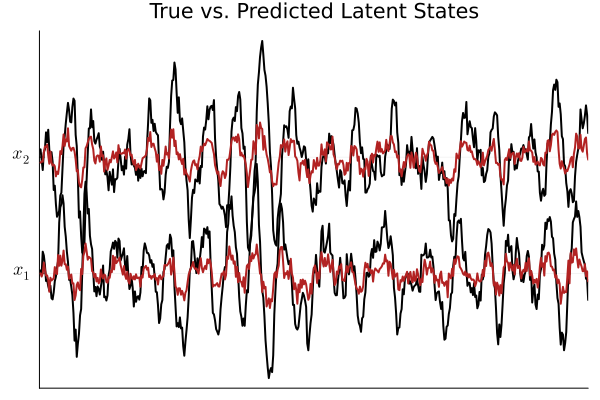

In [14]:
# create a Gaussian LDS with unknow parameters (except the dimensions)
naive_ssm = GaussianLDS(;obs_dim=obs_dim, latent_dim=latent_dim, fit_bool=fill(true, 6))

# smooth the data to look at the predicted latent states
x_smooth, p_smooth, _ = StateSpaceDynamics.smooth(naive_ssm, observations)

# create a plot to compare the true and predicted latent states
plot()

# plot the true latent states
for d in 1:state_dim
    plot!(1:time_bins, states[d, :] .+ lim_states * (d-1), color=:black, linewidth=2, label="", subplot=1)
end

# plot the predicted latent states
for d in 1:state_dim
    plot!(1:time_bins, x_smooth[d, :, 1] .+ lim_states * (d-1), color=:firebrick, linewidth=2, label="", subplot=1)
end

plot!(subplot=1, yticks=(lim_states .* (0:state_dim-1), [L"x_%$d" for d in 1:state_dim]),
      xticks=[], xlims=(0, time_bins), yformatter=y->"", tickfontsize=12, title="True vs. Predicted Latent States")


Fitting LDS via EM... 100%|██████████████████████████████████████████████████| Time: 0:00:07 (70.38 ms/it)


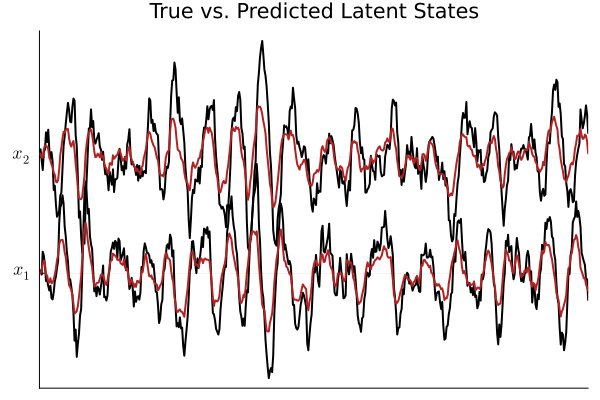

In [15]:
# now fit the LDS using the EM algorithm
elbo, _ = fit!(naive_ssm, observations; max_iter=100, tol=1e-6)

# smooth the data to look at the predicted latent states
x_smooth, p_smooth, _ = StateSpaceDynamics.smooth(naive_ssm, observations)

# create a plot to compare the true and predicted latent states
plot()

# plot the true latent states
for d in 1:state_dim
    plot!(1:time_bins, states[d, :] .+ lim_states * (d-1), color=:black, linewidth=2, label="", subplot=1)
end

# plot the predicted latent states
for d in 1:state_dim
    plot!(1:time_bins, x_smooth[d, :, 1] .+ lim_states * (d-1), color=:firebrick, linewidth=2, label="", subplot=1)
end

plot!(subplot=1, yticks=(lim_states .* (0:state_dim-1), [L"x_%$d" for d in 1:state_dim]),
      xticks=[], xlims=(0, time_bins), yformatter=y->"", tickfontsize=12, title="True vs. Predicted Latent States")

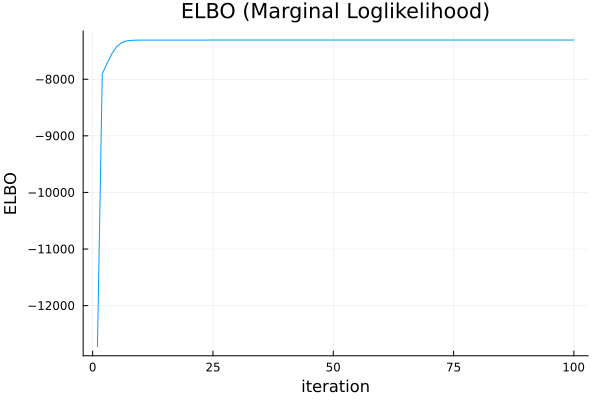

In [16]:
plot(elbo, xlabel="iteration", ylabel="ELBO", title="ELBO (Marginal Loglikelihood)", legend=false)